In [1]:
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import corner

In [2]:
import jax 
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax.nn import relu, elu
import optax 

from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [34]:
data = pd.read_csv('Data/mesa_data.csv')
data.head()

,Unnamed: 0,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,...,E_0_36,E_0_37,E_0_38,E_0_39,E_0_40,tau_he,delta_he,amp_he,tau_cz,dirname
0,0,profile4,152.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,...,0.000006,0.000002,0.000001,7.889056e-07,6.149682e-07,15247.850269,2037.139686,0.029961,38796.631185,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1
1,1,profile5,153.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,...,0.000008,0.000002,0.000001,8.212464e-07,6.273383e-07,14809.891105,1980.528826,0.029540,37900.327592,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1
2,2,profile6,154.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,...,0.000013,0.000003,0.000001,8.515127e-07,6.398741e-07,14496.838617,1940.585790,0.029221,37222.634389,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1
3,3,profile7,155.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,...,0.000018,0.000003,0.000001,8.790797e-07,6.513090e-07,14220.559706,1878.217087,0.028561,36703.539749,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1
4,4,profile8,156.0,0.0,0.8,0.32,0.036803,0.5,2.1,0.0,...,0.000027,0.000003,0.000001,9.036751e-07,6.612813e-07,14054.932771,1883.449431,0.028860,36302.082709,m0.8Y0.32FeH0.5MLT2.1ov0.0006666666666666673dif1


In [35]:
print(len(data))
data = data[data.star_age > 0.2]
data = data[data.effective_T < 6800]
data = data[data.nu_max > 600]
len(data)

253072


59785

In [36]:
icols = ['initial_mass',
 'initial_Yinit',
 'initial_Zinit',
 'initial_feh',
 'initial_MLT',
 'frac_age']

ocols = ['effective_T',
 'luminosity',
 'radius',
 'delta_nu',
 'nu_max',
 'surface_he4']

fcols = [f'nu_0_{n}' for n in range(12, 28)]

cols = fcols + icols + ocols

df = data[cols]

In [37]:
xs = df[icols].values
ys = df[fcols].values

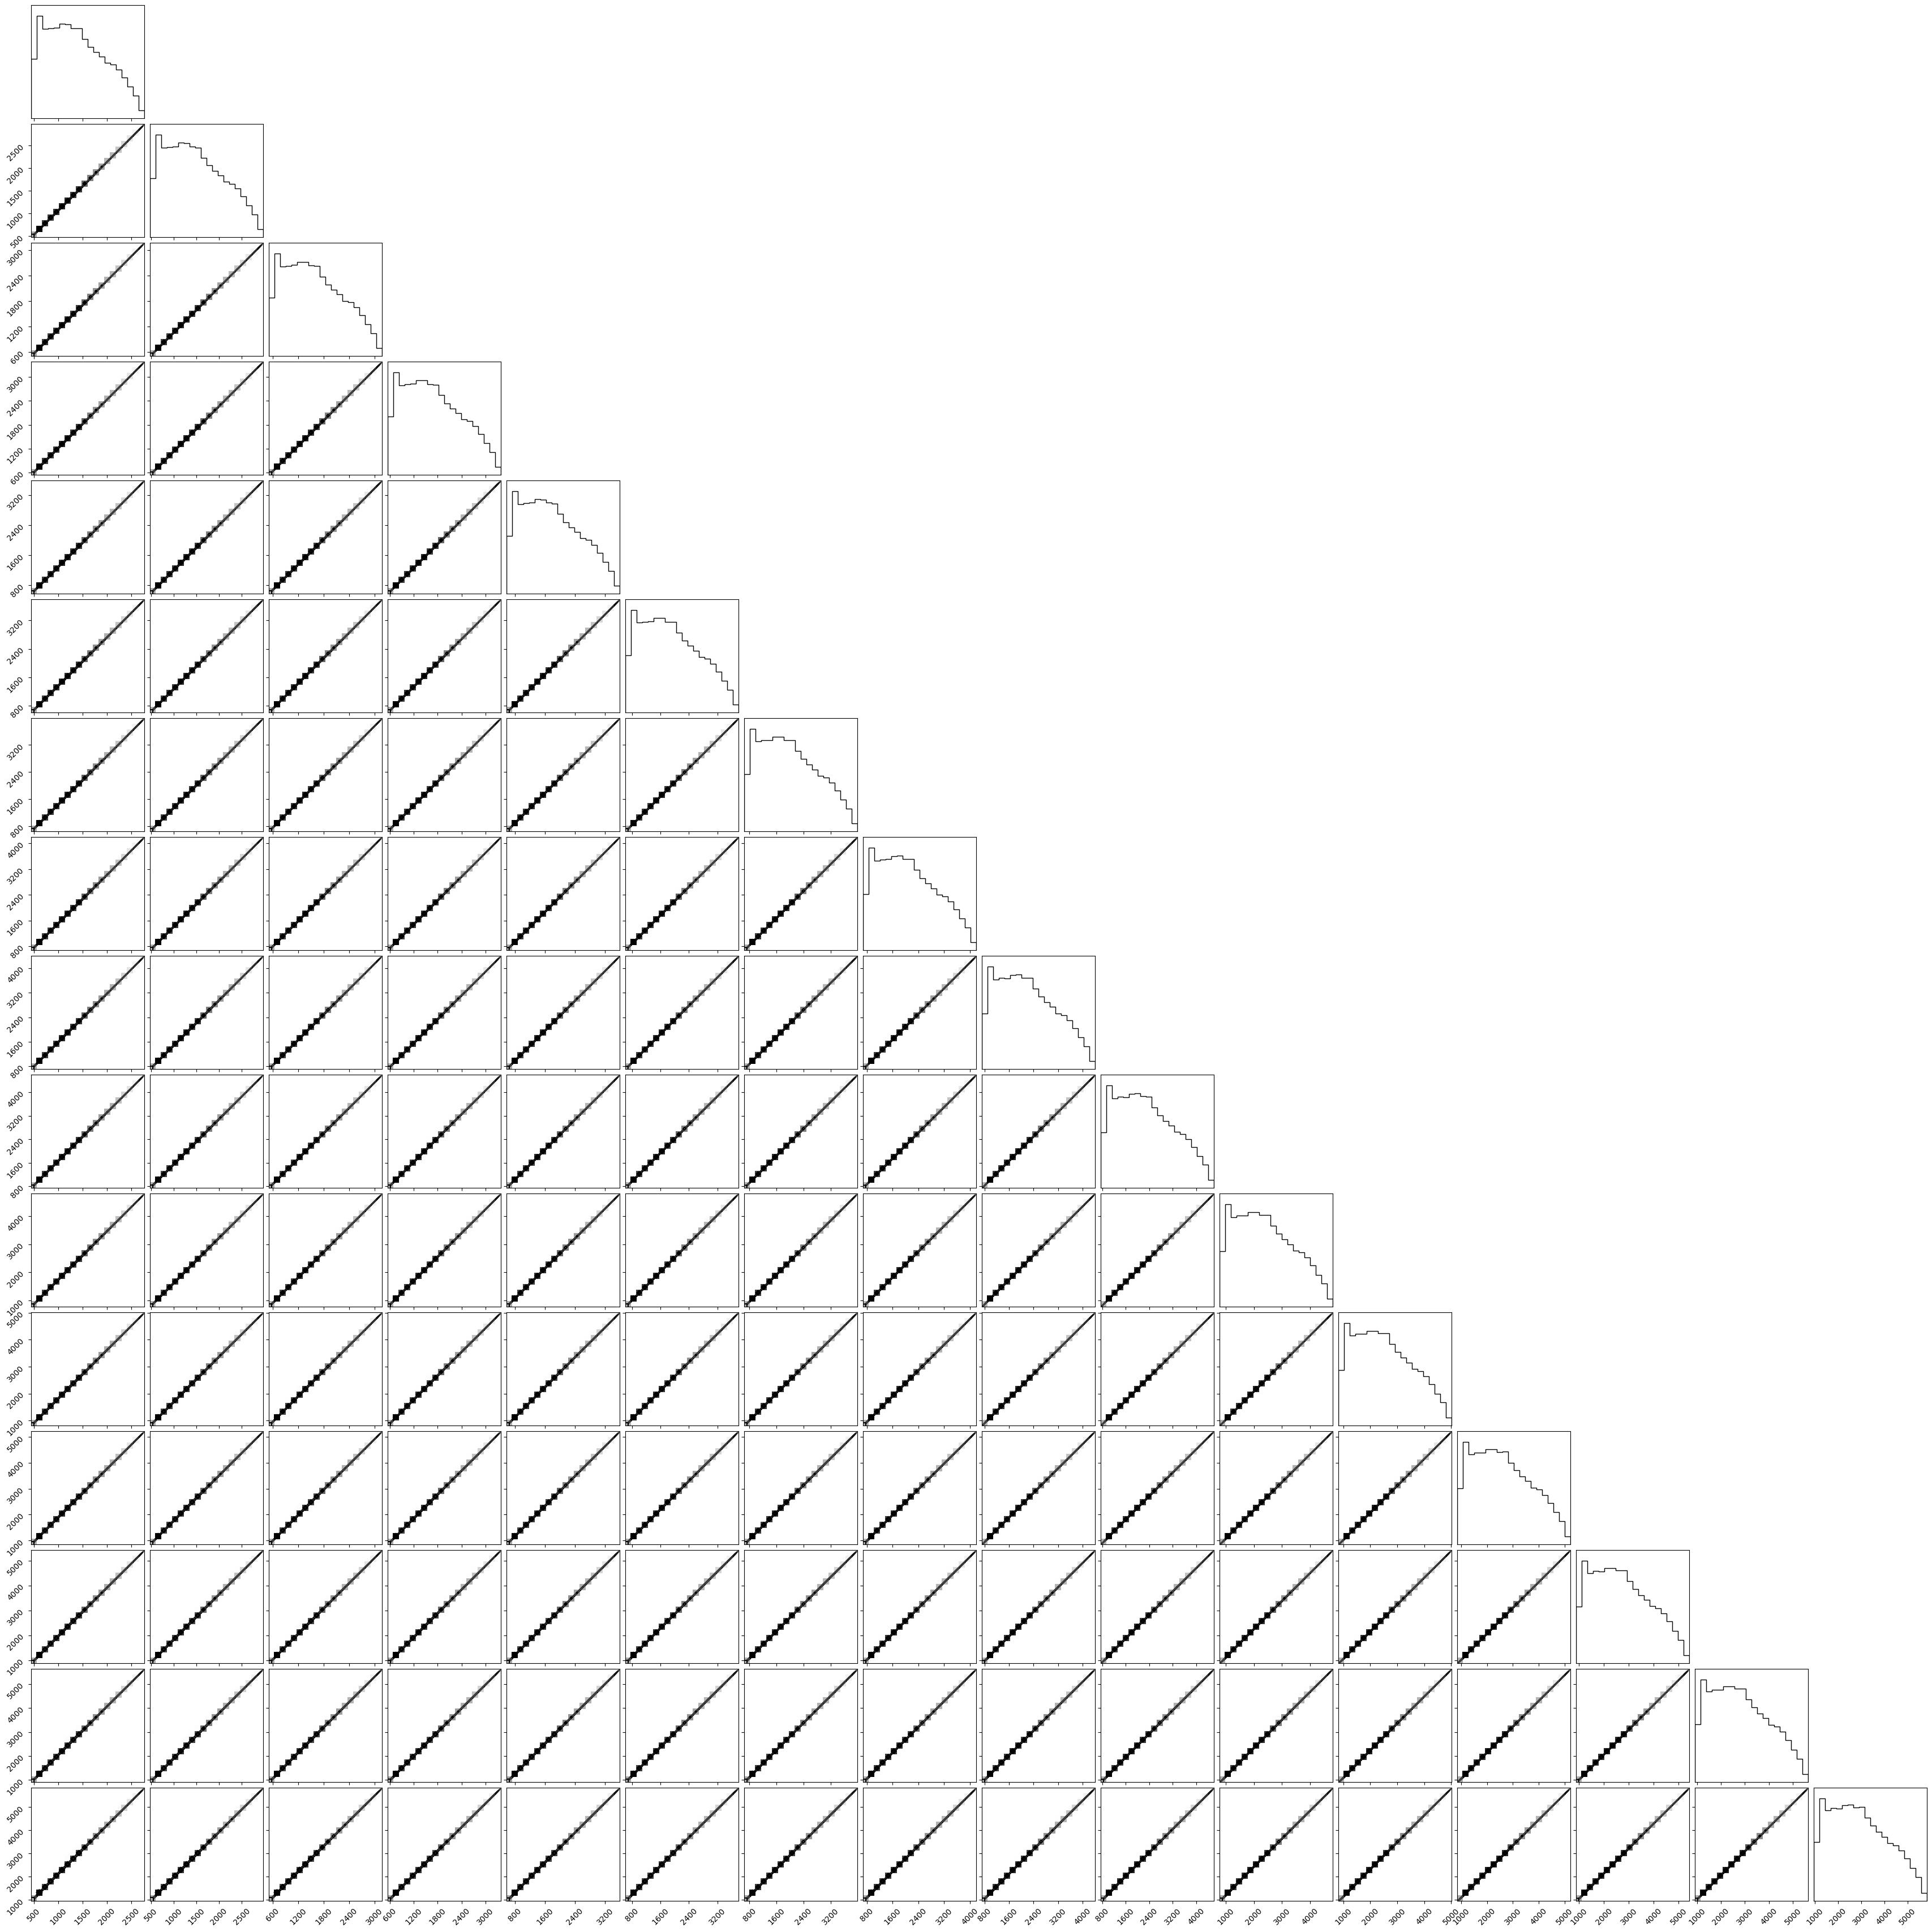

In [38]:
corner.corner(ys);

In [65]:
class pcann():
    def __init__(self, 
                 layer_sizes=[3, 5, 5, 2], 
                 key=random.PRNGKey(1)):
        self.params = self.initialize_mlp(layer_sizes, key)
        self.batch_forward = vmap(self.forward_pass, in_axes=(None, 0))
        
        
    def init_pca(self, n_components=4):
        self.pca = PCA(n_components=n_components)
        
    def fit_pca(self, ys):
        self.pca.fit(ys)
        print(f'PCA explained variance : {self.pca.explained_variance_ratio_}')
        print(f'PCA total explained variance : {sum(self.pca.explained_variance_ratio_)}')
        self.pca_comp = self.pca.components_
        self.pca_mean = self.pca.mean_
    
    def train(self, xs, ys, 
              lr=1e-1,
              epochs=100, 
              verbose=True):
        self.initialize_opt(lr=lr)
        for i in range(epochs):
            grads = jax.grad(self.loss)(self.params, xs, ys)
            updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
            self.params = optax.apply_updates(self.params, updates)
            if i%(epochs / 10) == 0 and verbose:
                print(f'Epoch {i}: Loss is {self.loss(self.params, xs, ys)}')
        
    def initialize_opt(self, lr=2e-2):
        self.optimizer = optax.adam(lr, b1=0.999)
        #self.optimizer = optax.sgd(lr)
        self.opt_state = self.optimizer.init(self.params)
        
    def pred(self, params, x):
        return self.batch_forward(params, x)
        
    def loss(self, params, x, y):
        preds = self.pred(params, x)
        loss = np.mean(optax.l2_loss(preds, y))
        return loss
        
    def forward_pass(self, params, x):
        """ Compute the forward pass for each example individually """
        activations = x

        # Loop over the hidden layers
        for w, b in params[:-1]:
            outputs = np.dot(w, activations) + b  # apply affine transformation
            activations = elu(outputs)  #  apply nonlinear activation

        # Perform final mlp output
        w, b = params[-1]
        outputs = (np.dot(w, activations) + b)
        
        # Add pca inverse transform to the output
        final_outputs = np.dot(outputs, self.pca_comp) + self.pca_mean
        return final_outputs
        
    def initialize_mlp(self, sizes, key):
        """ Initialize the weights of all layers of a linear layer network """
        keys = random.split(key, len(sizes))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, key, scale=1e-2):
            w_key, b_key = random.split(key)
            return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
        return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [74]:
pca_n_comps = 4
nn = pcann(layer_sizes = [len(icols), 64, 64, 64, pca_n_comps])
nn.init_pca(n_components=pca_n_comps)
nn.fit_pca(ys)
nn.train(np.asarray(xs), np.asarray(ys), lr=5e-2, epochs=20000)

PCA explained variance : [9.99989037e-01 9.65322283e-06 8.13465430e-07 1.99019859e-07]
PCA total explained variance : 0.9999997028354557
Epoch 0: Loss is 413974.65625
Epoch 2000: Loss is 3988.497314453125
Epoch 4000: Loss is 1934.59228515625
Epoch 6000: Loss is 1214.009033203125
Epoch 8000: Loss is 596.8350219726562
Epoch 10000: Loss is 394.9400939941406
Epoch 12000: Loss is 301.3979187011719
Epoch 14000: Loss is 264.5217590332031
Epoch 16000: Loss is 237.56314086914062
Epoch 18000: Loss is 211.63107299804688


In [75]:
preds = nn.pred(nn.params, xs)

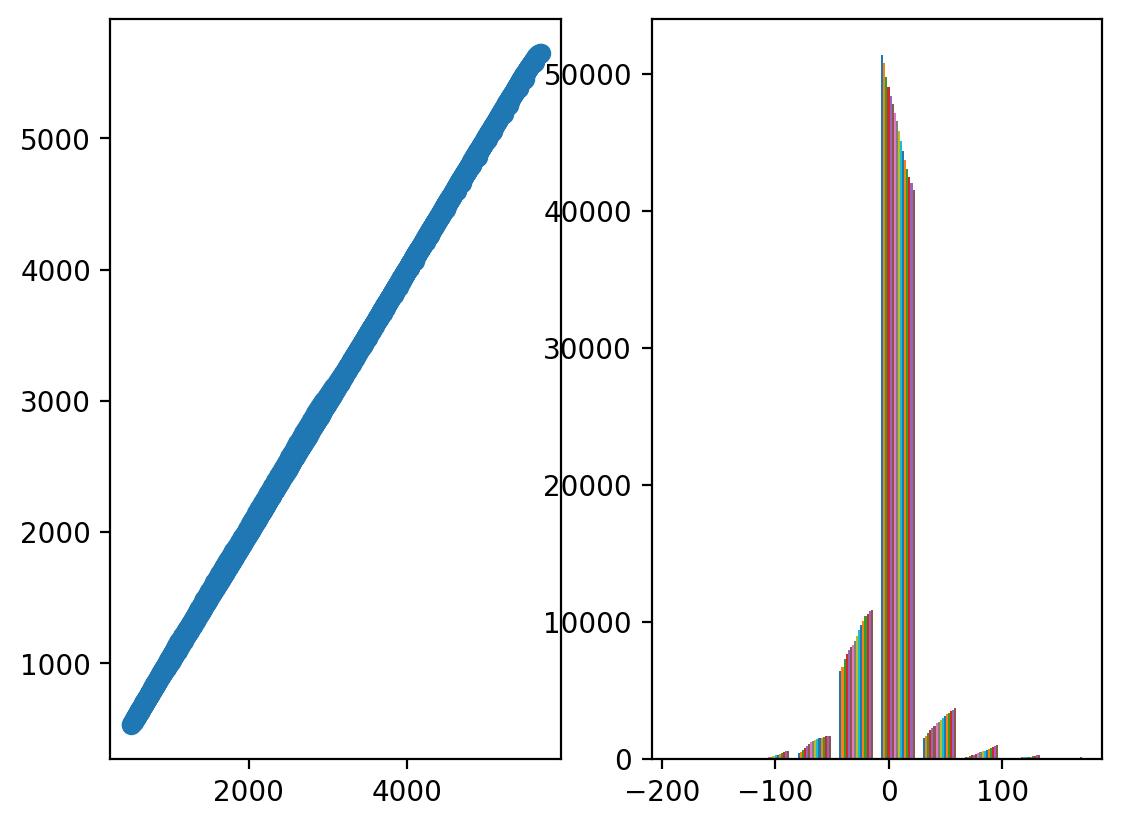

In [76]:
fig, ax = plt.subplots(1, 2, dpi=200)

n = 1000

ax[0].scatter(ys[:n, ...], preds[:n, ...])

ax[1].hist(onp.array(ys - preds));

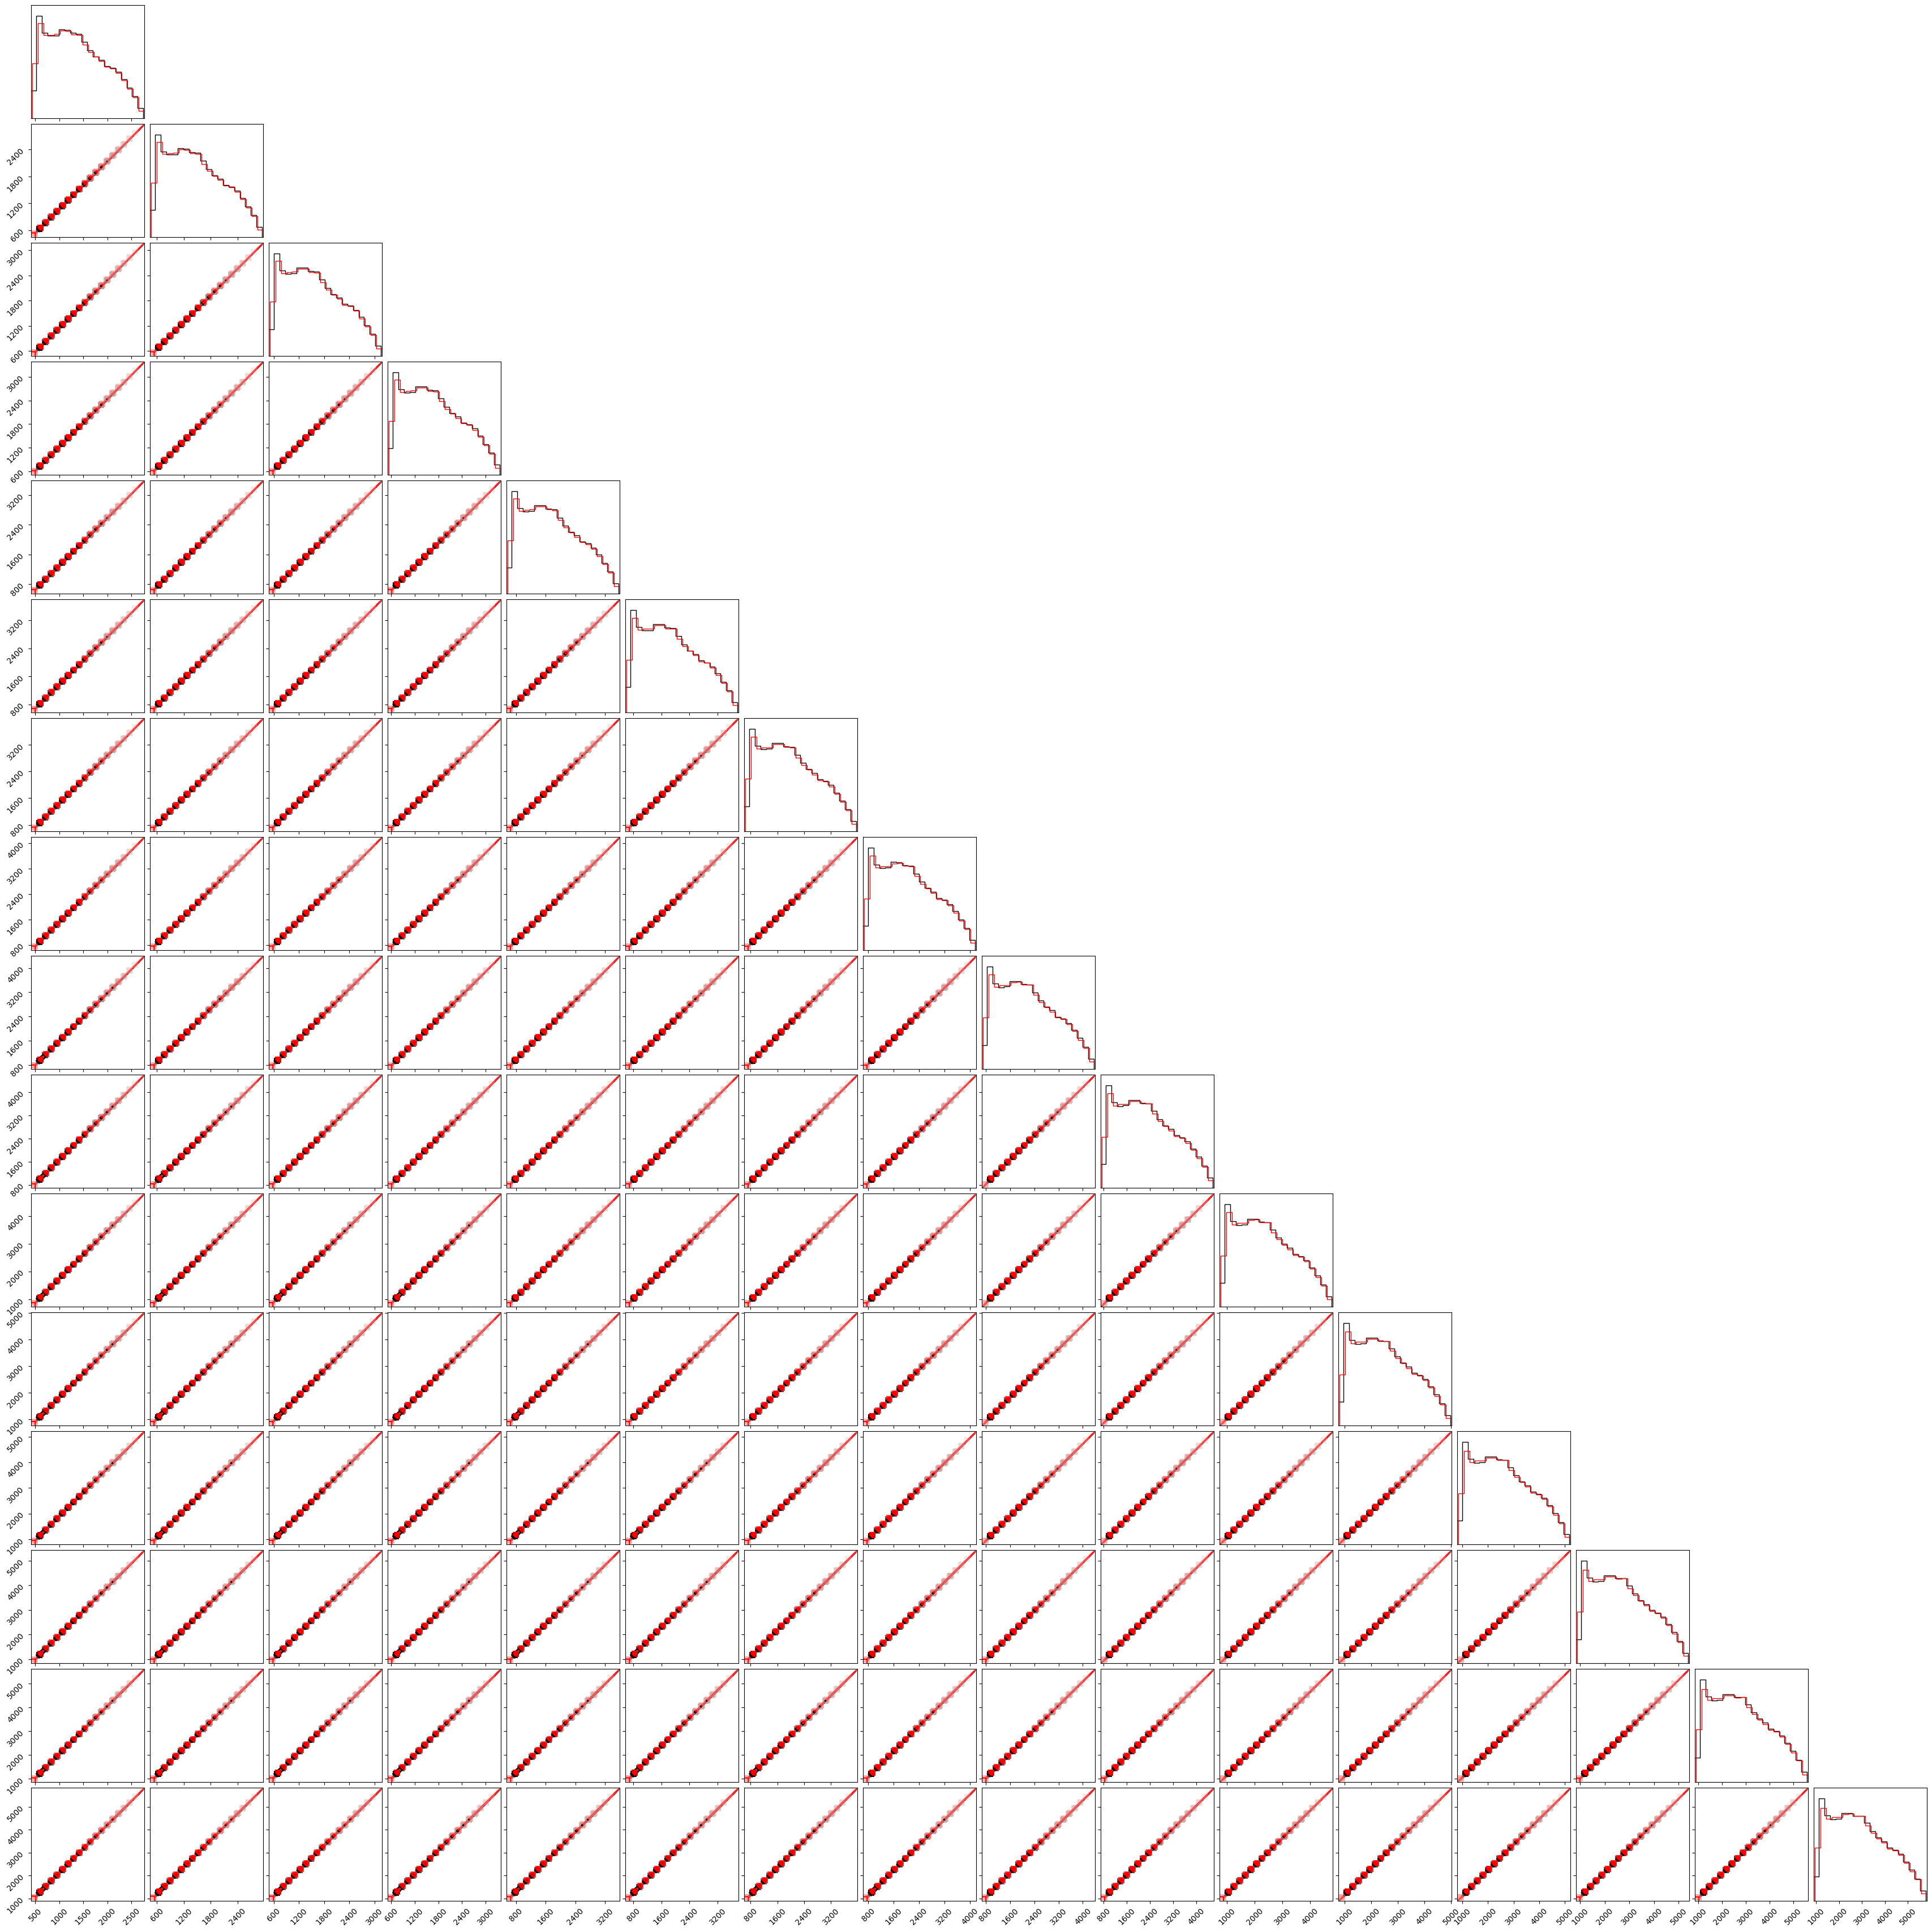

In [77]:
fig = corner.corner(onp.array(preds), color='k');
corner.corner(onp.array(ys), fig=fig, color='r');